In [ ]:
!pip install tensorflow==2.19.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator
layers = tf.keras.layers
models = tf.keras.models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import cv2
import os


In [ ]:
dataset_path = "/content/drive/MyDrive/data/train"

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

num_classes = len(train_generator.class_indices)

Found 2400 images belonging to 5 classes.
Found 600 images belonging to 5 classes.


In [ ]:

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*IMG_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
import tensorflow as tf

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.argmax(y_true, axis=1)

        y_pred = tf.cast(y_pred, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        self.tp.assign_add(tf.reduce_sum(y_true * y_pred))
        self.fp.assign_add(tf.reduce_sum((1 - y_true) * y_pred))
        self.fn.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

    def result(self):
        precision = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
        recall = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
        return 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())

    def reset_states(self):
        self.tp.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        F1Score()
    ]
)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,285 (12.61 MB)

 Trainable params: 3,305,285 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30
)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 301ms/step - accuracy: 0.7301 - f1_score: 2.7441 - loss: 0.7638 - val_accuracy: 0.7700 - val_f1_score: 2.8764 - val_loss: 0.6520
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 315ms/step - accuracy: 0.7171 - f1_score: 2.7582 - loss: 0.7530 - val_accuracy: 0.7683 - val_f1_score: 2.6848 - val_loss: 0.6667
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 331ms/step - accuracy: 0.7478 - f1_score: 2.7953 - loss: 0.7349 - val_accuracy: 0.8033 - val_f1_score: 2.7568 - val_loss: 0.5995
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 307ms/step - accuracy: 0.7580 - f1_score: 2.7974 - loss: 0.7112 - val_accuracy: 0.7850 - val_f1_score: 2.8173 - val_loss: 0.6114
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 317ms/step - accuracy: 0.7534 - f1_score: 2.7609 - loss: 0.7022 - val_accuracy: 0.8167 - val_f1_score: 2.8401 - val_loss: 0.5699
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 303ms/step - accuracy: 0.7652 - f1_score: 2.7801 - loss: 0.7004 - val_accuracy: 0.7950 - val_f1_score: 

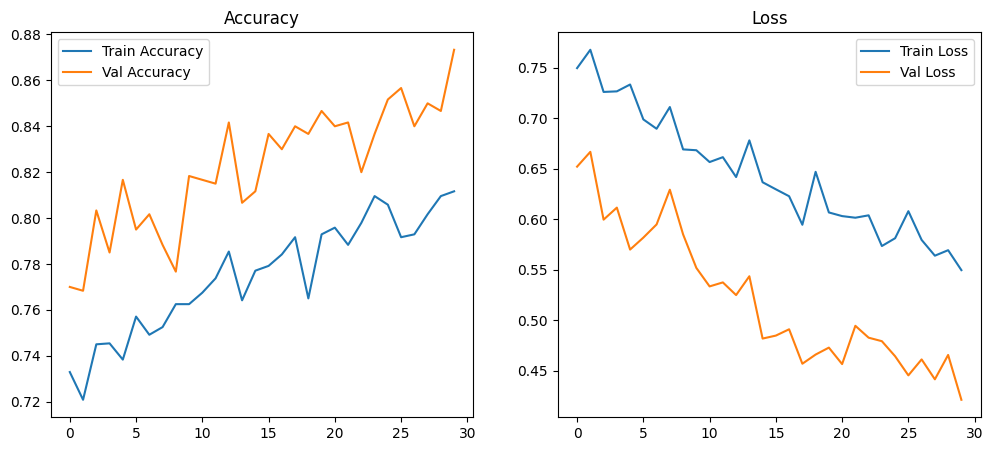

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()


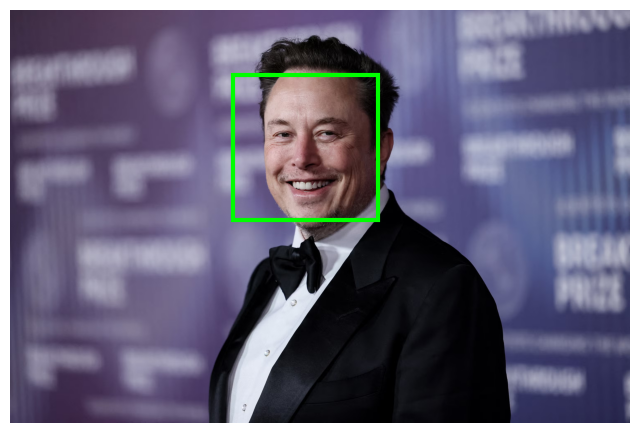

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted: elon_musk
Confidence: 93.05%


In [ ]:
def predict_image(img_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("No face detected!")
        return

    x, y, w, h = max(faces, key=lambda f: f[2] * f[3])

    padding = int(0.1 * max(w, h))
    x_pad = max(0, x - padding)
    y_pad = max(0, y - padding)
    w_pad = min(img_rgb.shape[1] - x_pad, w + 2 * padding)
    h_pad = min(img_rgb.shape[0] - y_pad, h + 2 * padding)

    face_crop = img_rgb[y_pad:y_pad+h_pad, x_pad:x_pad+w_pad]

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(img_rgb)
    rect = Rectangle((x_pad, y_pad), w_pad, h_pad, linewidth=3, edgecolor='lime', facecolor='none')
    ax.add_patch(rect)
    ax.axis('off')
    plt.show()

    face_resized = tf.image.resize(face_crop, IMG_SIZE)
    img_array = face_resized.numpy() / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction)
    confidence = prediction[0][class_idx]  # Get confidence score
    class_labels = list(train_generator.class_indices.keys())

    print(f"Predicted: {class_labels[class_idx]}")
    print(f"Confidence: {confidence:.2%}")  # Display as percentage with 2 decimal places

predict_image("/content/elon-musk-gettyimages-2147789844-web-675b2c17301ea.avif")